# LabEvoMod

A Simulation tool for laboratory evolution experiments

In [10]:
import math
import random
import uuid
import copy
from collections import Counter
import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_line, geom_point, theme_classic, geom_bar, 
scale_fill_discrete, theme, stat_summary, options, ylim)

In [22]:
class Evo(object):
    def __init__(self, dilution, start, limit):
        t0_strain = Strain(0, 0)
        self.cells = [Cell(t0_strain) for i in range(start)]
        self.strains = set([cell.strain for cell in self.cells])
        self.dilution = dilution
        self.limit = limit
        self.neg_strains = set()
        self.pos_strains = set()
        self.neu_strains = set()
        self.dils = 0
        self.strain_dict = {}
        self.pos_strain_dict = {}
        self.neg_strain_dict = {}
        self.neu_strain_dict = {}
        
    def step(self):
        # 1 step is ~1 min for E. coli
        # Shuffle every step so cells at the beginning of list don't get priority
        random.shuffle(self.cells)
        new_cells = []
        for cell in self.cells:
            
            # Calculate probability of division
            prob = cell.growth_func
            if random.choices([0, 1], [1-prob, prob])[0] == 1:  
                new_cell = Cell(cell.strain)
                
                # Check if new cell mutates (1 in 1000)
                if random.randint(0, 999) == 999:
                    # Mutation type proportions are estimates
                    mut_type = random.choices(['letl','neg', 'neu', 'pos'], [0.15, 0.3, 0.54, 0.01])[0]
                    new_strain = Strain(uuid.uuid4(), new_cell.strain.growth_param)
                    if mut_type == 'letl':
                        # Lethal mutation prevents further division, but does not remove the cell from the culture
                        new_strain.growth_param = 1000000
                    elif mut_type == 'neg':
                        # Negative mutations increase g from parent by a random amount from the below uniform distributin
                        new_strain.growth_param += random.uniform(0.5, 2)
                    elif mut_type == 'pos':
                        # And the same for positive mutations, but g is decreased from parent
                        new_strain.growth_param -= random.uniform(0.5, 2)
                    
                    if new_strain.growth_param > 0:
                        self.neg_strains.add(new_strain)
                    elif new_strain.growth_param < 0:
                        self.pos_strains.add(new_strain)
                    elif new_strain.growth_param == 0:
                        self.neu_strains.add(new_strain)
                    new_cell.strain = new_strain
                    
                # Both cells have their division clocks reset
                cell.last_divide = 0
                new_cell.last_divide = 0
                new_cells.append(new_cell)
            
            else:
                # If no division happens, division clock increased
                cell.last_divide += 1
            
            # If the number of cells in the population is at limit, then dilute
            if len(self.cells) + len(new_cells) == self.limit:
                self.cells += new_cells
                self.strains = set([cell.strain for cell in self.cells])
                self.dilute()
                break
        
        # If after a step is fully completed limit is not reached, just add all new cells and start again
        self.cells += new_cells
        self.strains = set([cell.strain for cell in self.cells])
    
    
    def dilute(self):
        self.dils += 1
        strain_counts = Counter([cell.strain for cell in self.cells])
        self.strain_dict[self.dils] = strain_counts
        self.pos_strain_dict[self.dils] = {strain: num for strain, num in strain_counts.items() if strain in self.pos_strains}
        self.neg_strain_dict[self.dils] = {strain: num for strain, num in strain_counts.items() if strain in self.neg_strains}
        self.neu_strain_dict[self.dils] = {strain: num for strain, num in strain_counts.items() if strain in self.neu_strains}

        self.cells = random.sample(self.cells, int(len(self.cells)/self.dilution))
        for cell in self.cells:
            cell.last_divide = 0
        print(f'Dilution: {self.dils}')
        
    def run(self, max_dil):
        while self.dils < max_dil:
            self.step()

class Strain(object):
     def __init__(self, name, growth_param):
        self.name = name
        self.growth_param = growth_param
        
            
class Cell(object):
    def __init__(self, strain):
        self.strain = strain
        self.last_divide = 0
   
    @property
    def growth_func(self):
        inner_func = (((1/(1+math.e**-self.strain.growth_param))+0.0001*self.strain.growth_param+1.5)/2)
        return (math.tanh(self.last_divide/5 - 5*inner_func)+1)/2

In [25]:
Evo100 = Evo(100, 1000, 200000) # 100x dilution rate, 1000 initial cells, dilute when 200,000 cells reached
Evo100.run(50) # run for 50 dilutions

Dilution: 1
Dilution: 2
Dilution: 3
Dilution: 4
Dilution: 5
Dilution: 6
Dilution: 7
Dilution: 8
Dilution: 9
Dilution: 10
Dilution: 11
Dilution: 12
Dilution: 13
Dilution: 14
Dilution: 15
Dilution: 16
Dilution: 17
Dilution: 18
Dilution: 19
Dilution: 20
Dilution: 21
Dilution: 22
Dilution: 23
Dilution: 24
Dilution: 25
Dilution: 26
Dilution: 27
Dilution: 28
Dilution: 29
Dilution: 30
Dilution: 31
Dilution: 32
Dilution: 33
Dilution: 34
Dilution: 35
Dilution: 36
Dilution: 37
Dilution: 38
Dilution: 39
Dilution: 40
Dilution: 41
Dilution: 42
Dilution: 43
Dilution: 44
Dilution: 45
Dilution: 46
Dilution: 47
Dilution: 48
Dilution: 49
Dilution: 50


In [27]:
def trajectory(strain_dict, plots='all', file_stem=None, other=True, prop=0.0025):
    e_trajectory = {}
    max_gs = {}
    modal_gs = {}
    avg_gs = {}
    total_cells = sum(strain_dict[1].values())
    thresh = round(total_cells*prop)
    for i, d in strain_dict.items():
        i_dict = {}
        if other:
            other_tot = 0
        max_g = 0
        max_v = 0
        max_v_growth_param = 0
        cum_g_sum = 0
        cum_v_sum = 0
        for s, v in d.items():
            if v >= thresh:
                i_dict[s] = v
            else:
                if other:
                    other_tot += v
            if s.growth_param < max_g:
                max_g = s.growth_param
            if v > max_v:
                max_v = v
                max_v_growth_param = s.growth_param
            if s.growth_param < 10000:
                cum_g_sum += v * s.growth_param
                cum_v_sum += v
         
        if other:
            i_dict['other'] = other_tot
            
        e_trajectory[i] = i_dict
        
        if plots == 'all':
            max_gs[i] = max_g
            modal_gs[i] = max_v_growth_param
            avg_gs[i] = cum_g_sum/cum_v_sum

    df = pd.DataFrame().from_dict(e_trajectory, orient='index')
    df = df.reset_index()
    df = df.rename(columns={'index': 't'})
    df = df.melt('t')
    df = df.dropna()
    df.variable = df.variable.astype('category')
    
    df.to_csv(f'{file_stem}_traj.csv')
    
    options.figure_size = (10, 10)
    
    plot1 = ggplot(df, aes('t', 'value', fill='variable')) + geom_bar(stat='identity') + theme_classic() + \
    theme(legend_position='none')
    
    if file_stem:
        ggsave(plot1, f'{file_stem}_trajectory.pdf', dpi=1000)
    
    if plots == 'all':
        gdf = pd.DataFrame().from_dict(max_gs, orient='index')
        gdf = gdf.reset_index()
        gdf.columns = ['t', 'max_g']
        gdf.to_csv(f'{file_stem}_max.csv')

        mdf = pd.DataFrame().from_dict(modal_gs, orient='index')
        mdf = mdf.reset_index()
        mdf.columns = ['t', 'mode_g']
        mdf.to_csv(f'{file_stem}_mode.csv')

        adf = pd.DataFrame().from_dict(avg_gs, orient='index')
        adf = adf.reset_index()
        adf.columns = ['t', 'avg_g']
        adf.to_csv(f'{file_stem}_avg.csv')
        
        
        options.figure_size = (3.3, 5)

        plot2 = ggplot(gdf, aes('t', 'max_g')) + geom_point(size=3) + theme_classic() + ylim(-7, 1)

        plot3 = ggplot(mdf, aes('t', 'mode_g')) + geom_point(size=3) + theme_classic() + ylim(-7, 1)

        plot4 = ggplot(adf, aes('t', 'avg_g')) + geom_point(size=3) + theme_classic() + ylim(-7, 1)
        
        if file_stem:
            ggsave(plot2, f'{file_stem}_best.pdf', dpi=1000)
            ggsave(plot3, f'{file_stem}_modal.pdf', dpi=1000)
            ggsave(plot4, f'{file_stem}_avg.pdf', dpi=1000)
            
        return plot1, plot2, plot3, plot4
    
    elif plots == 'some':
        return plot1
     

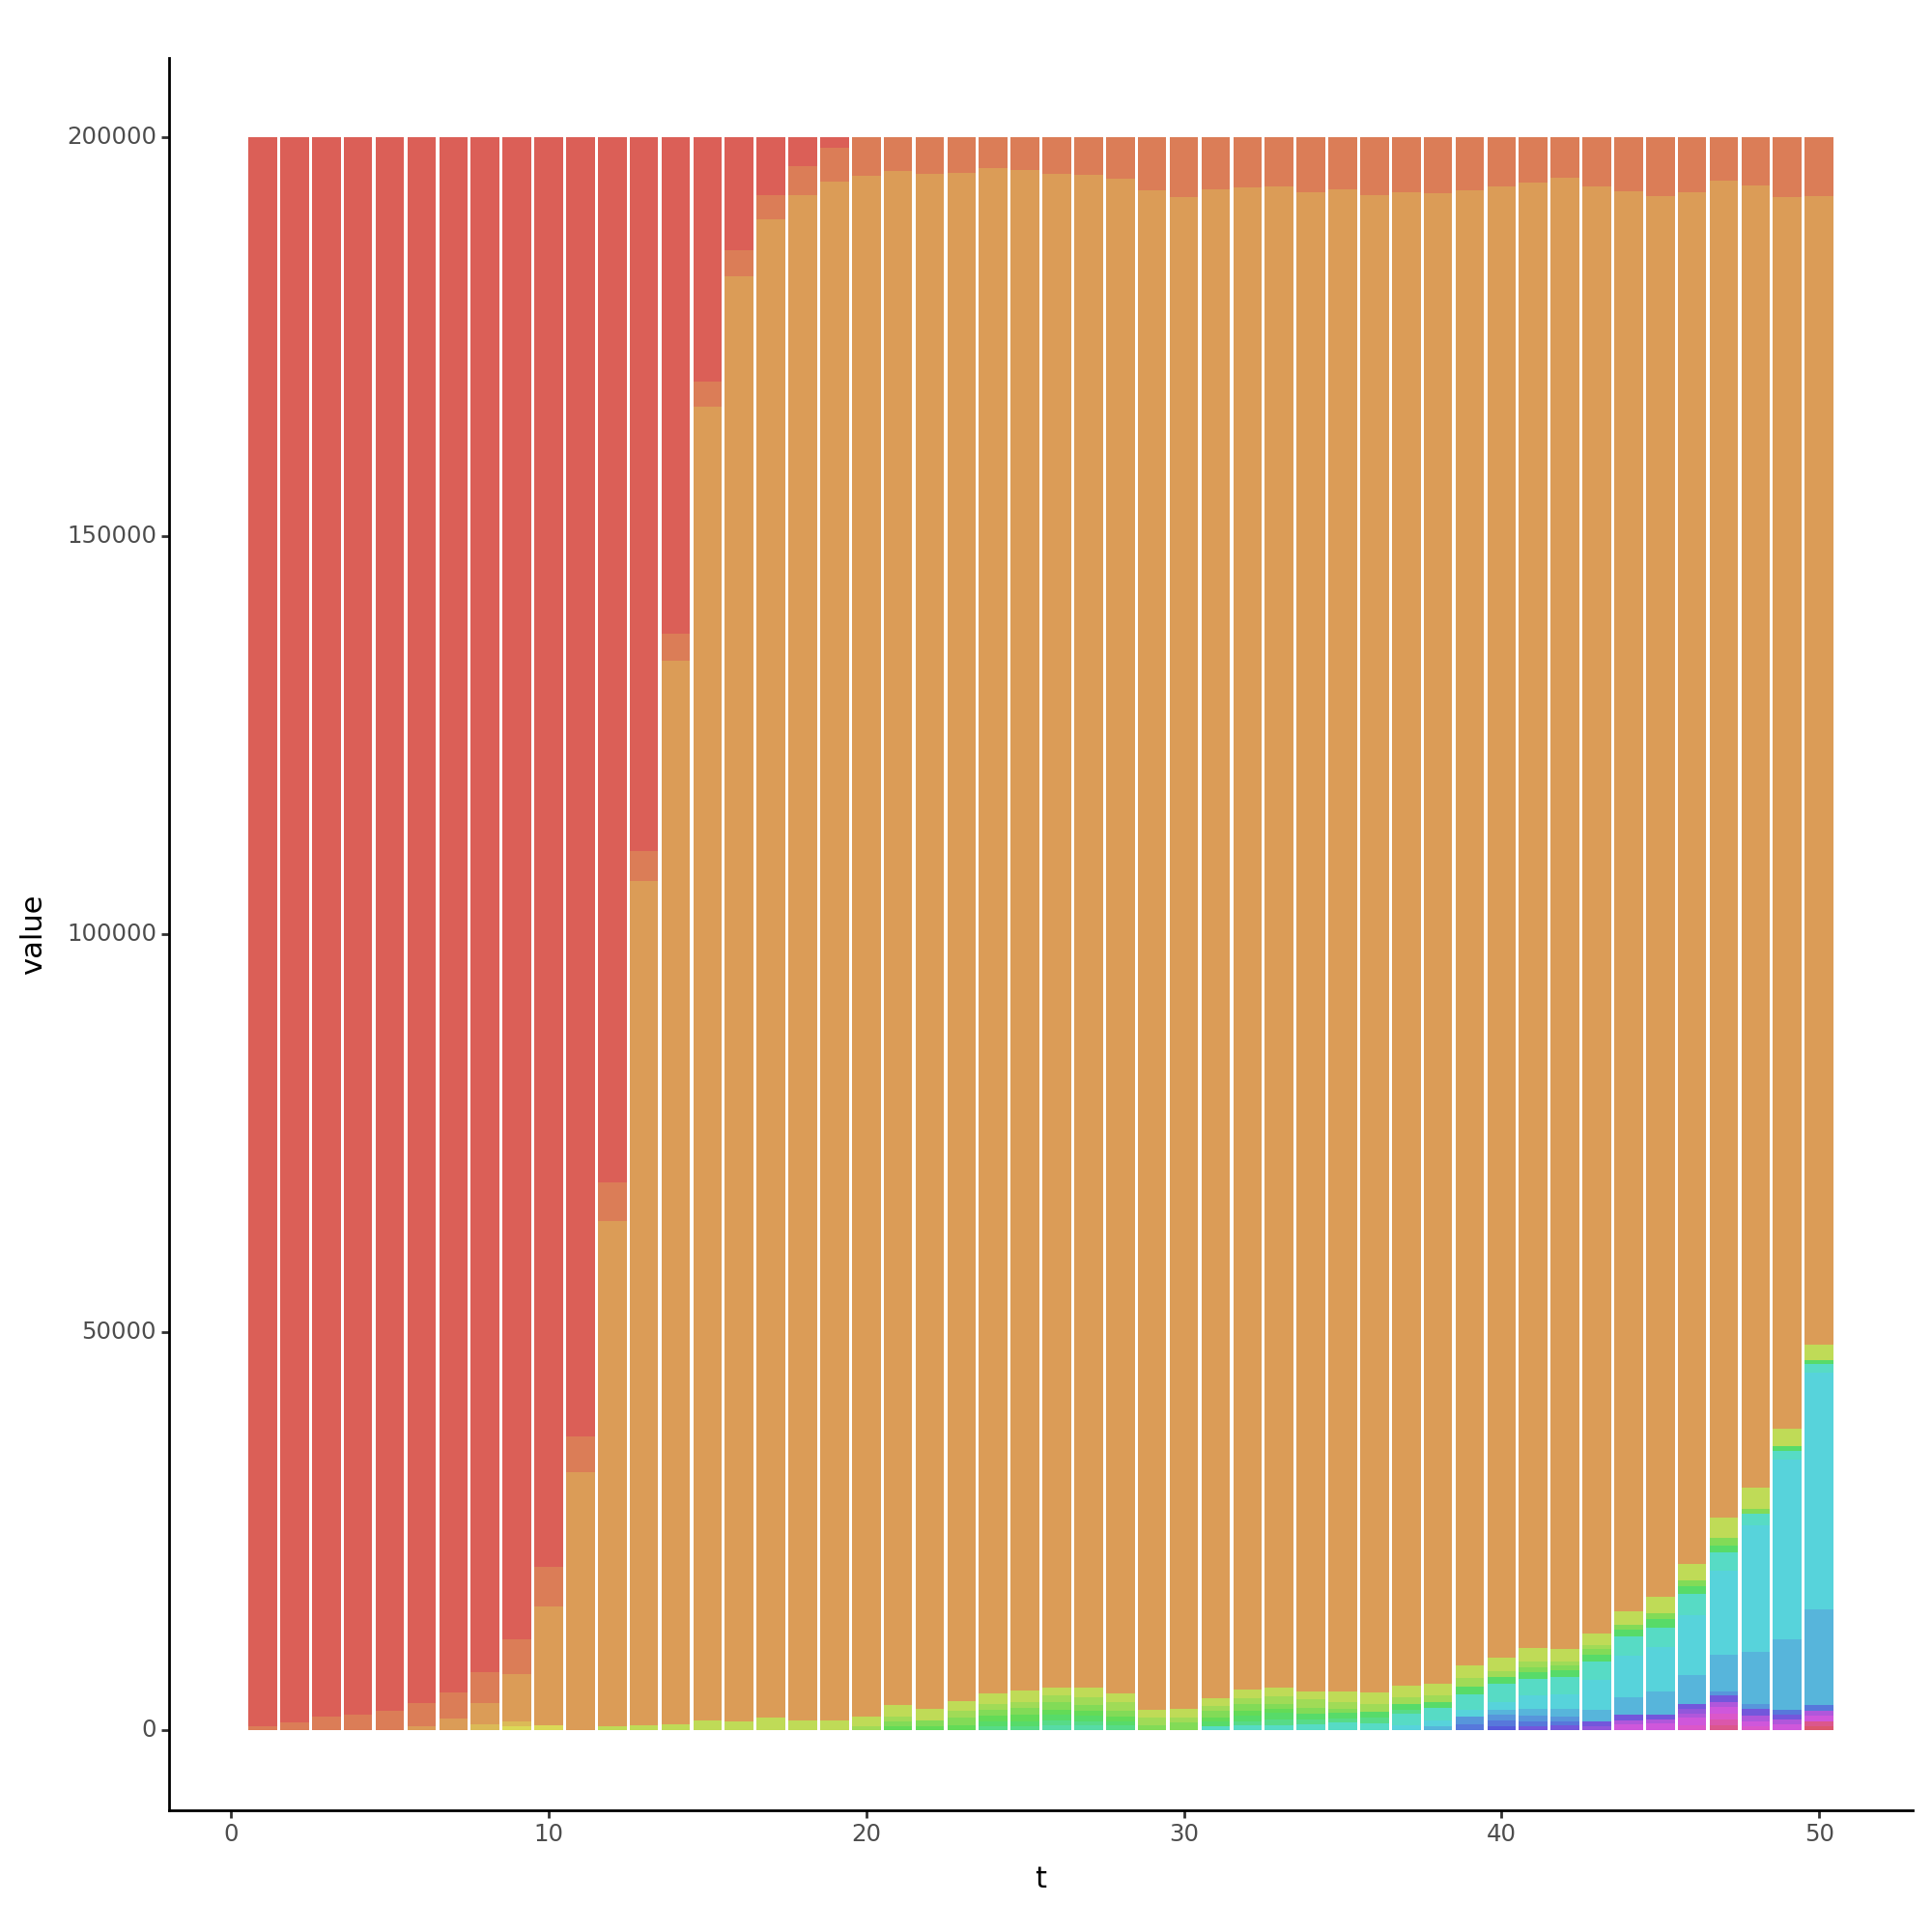

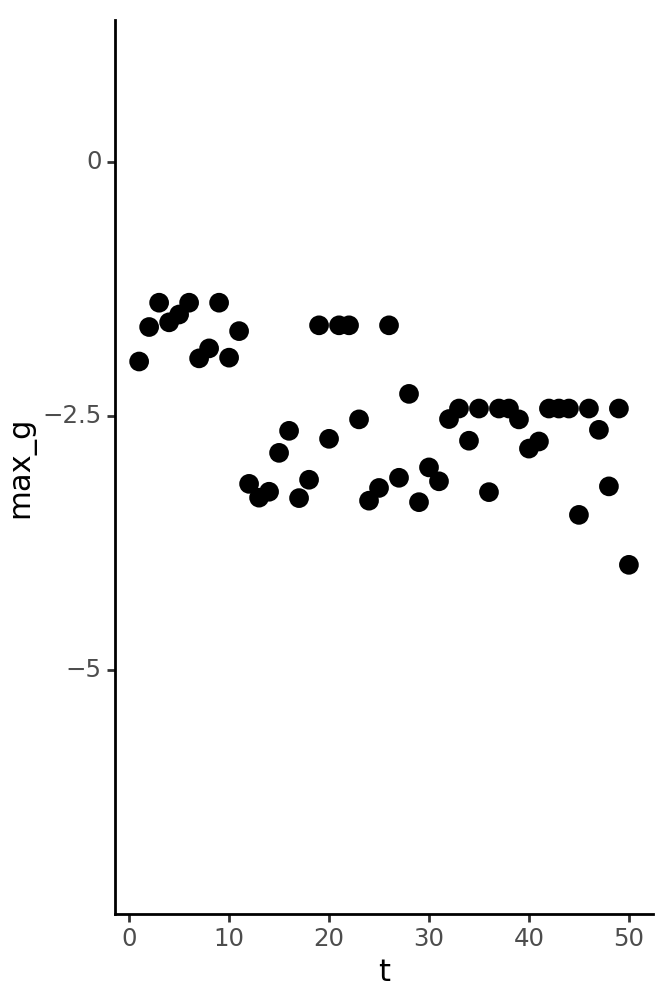

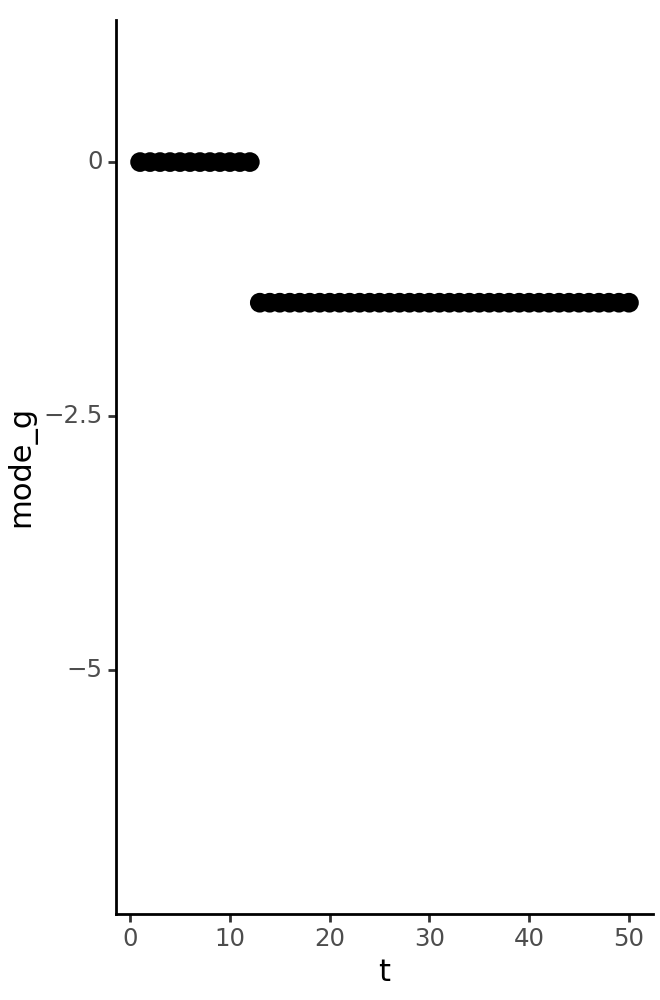

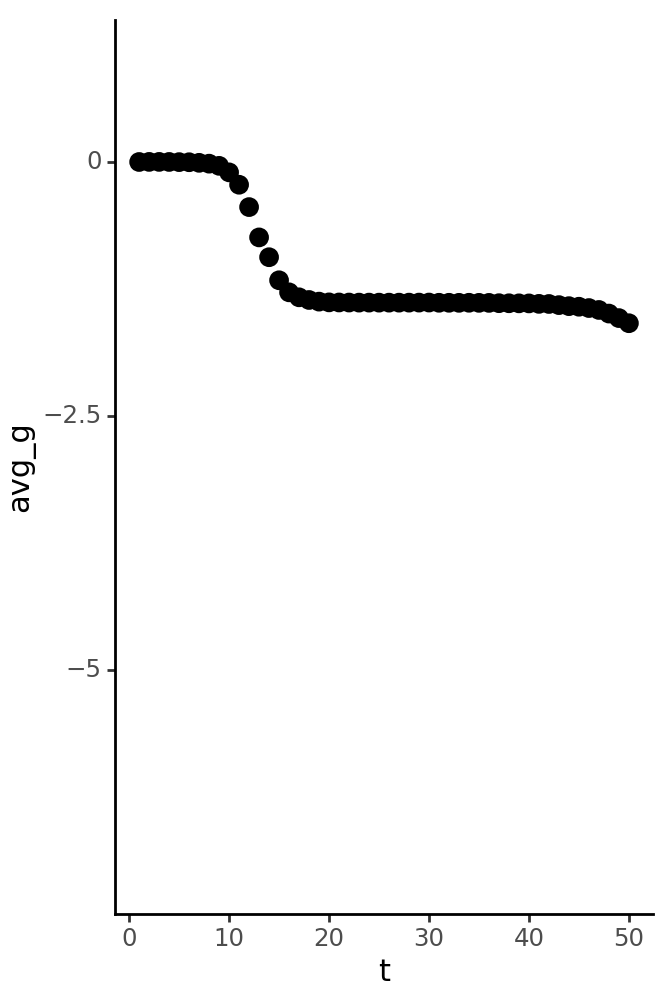

(<Figure Size: (1000 x 1000)>,
 <Figure Size: (330 x 500)>,
 <Figure Size: (330 x 500)>,
 <Figure Size: (330 x 500)>)

In [28]:
trajectory(Evo100.strain_dict, plots='all')

In [29]:
Evo100_beneficial = {i: {s: v for s, v in d.items() if s.growth_param < 0} for i, d in Evo100.strain_dict.items()}

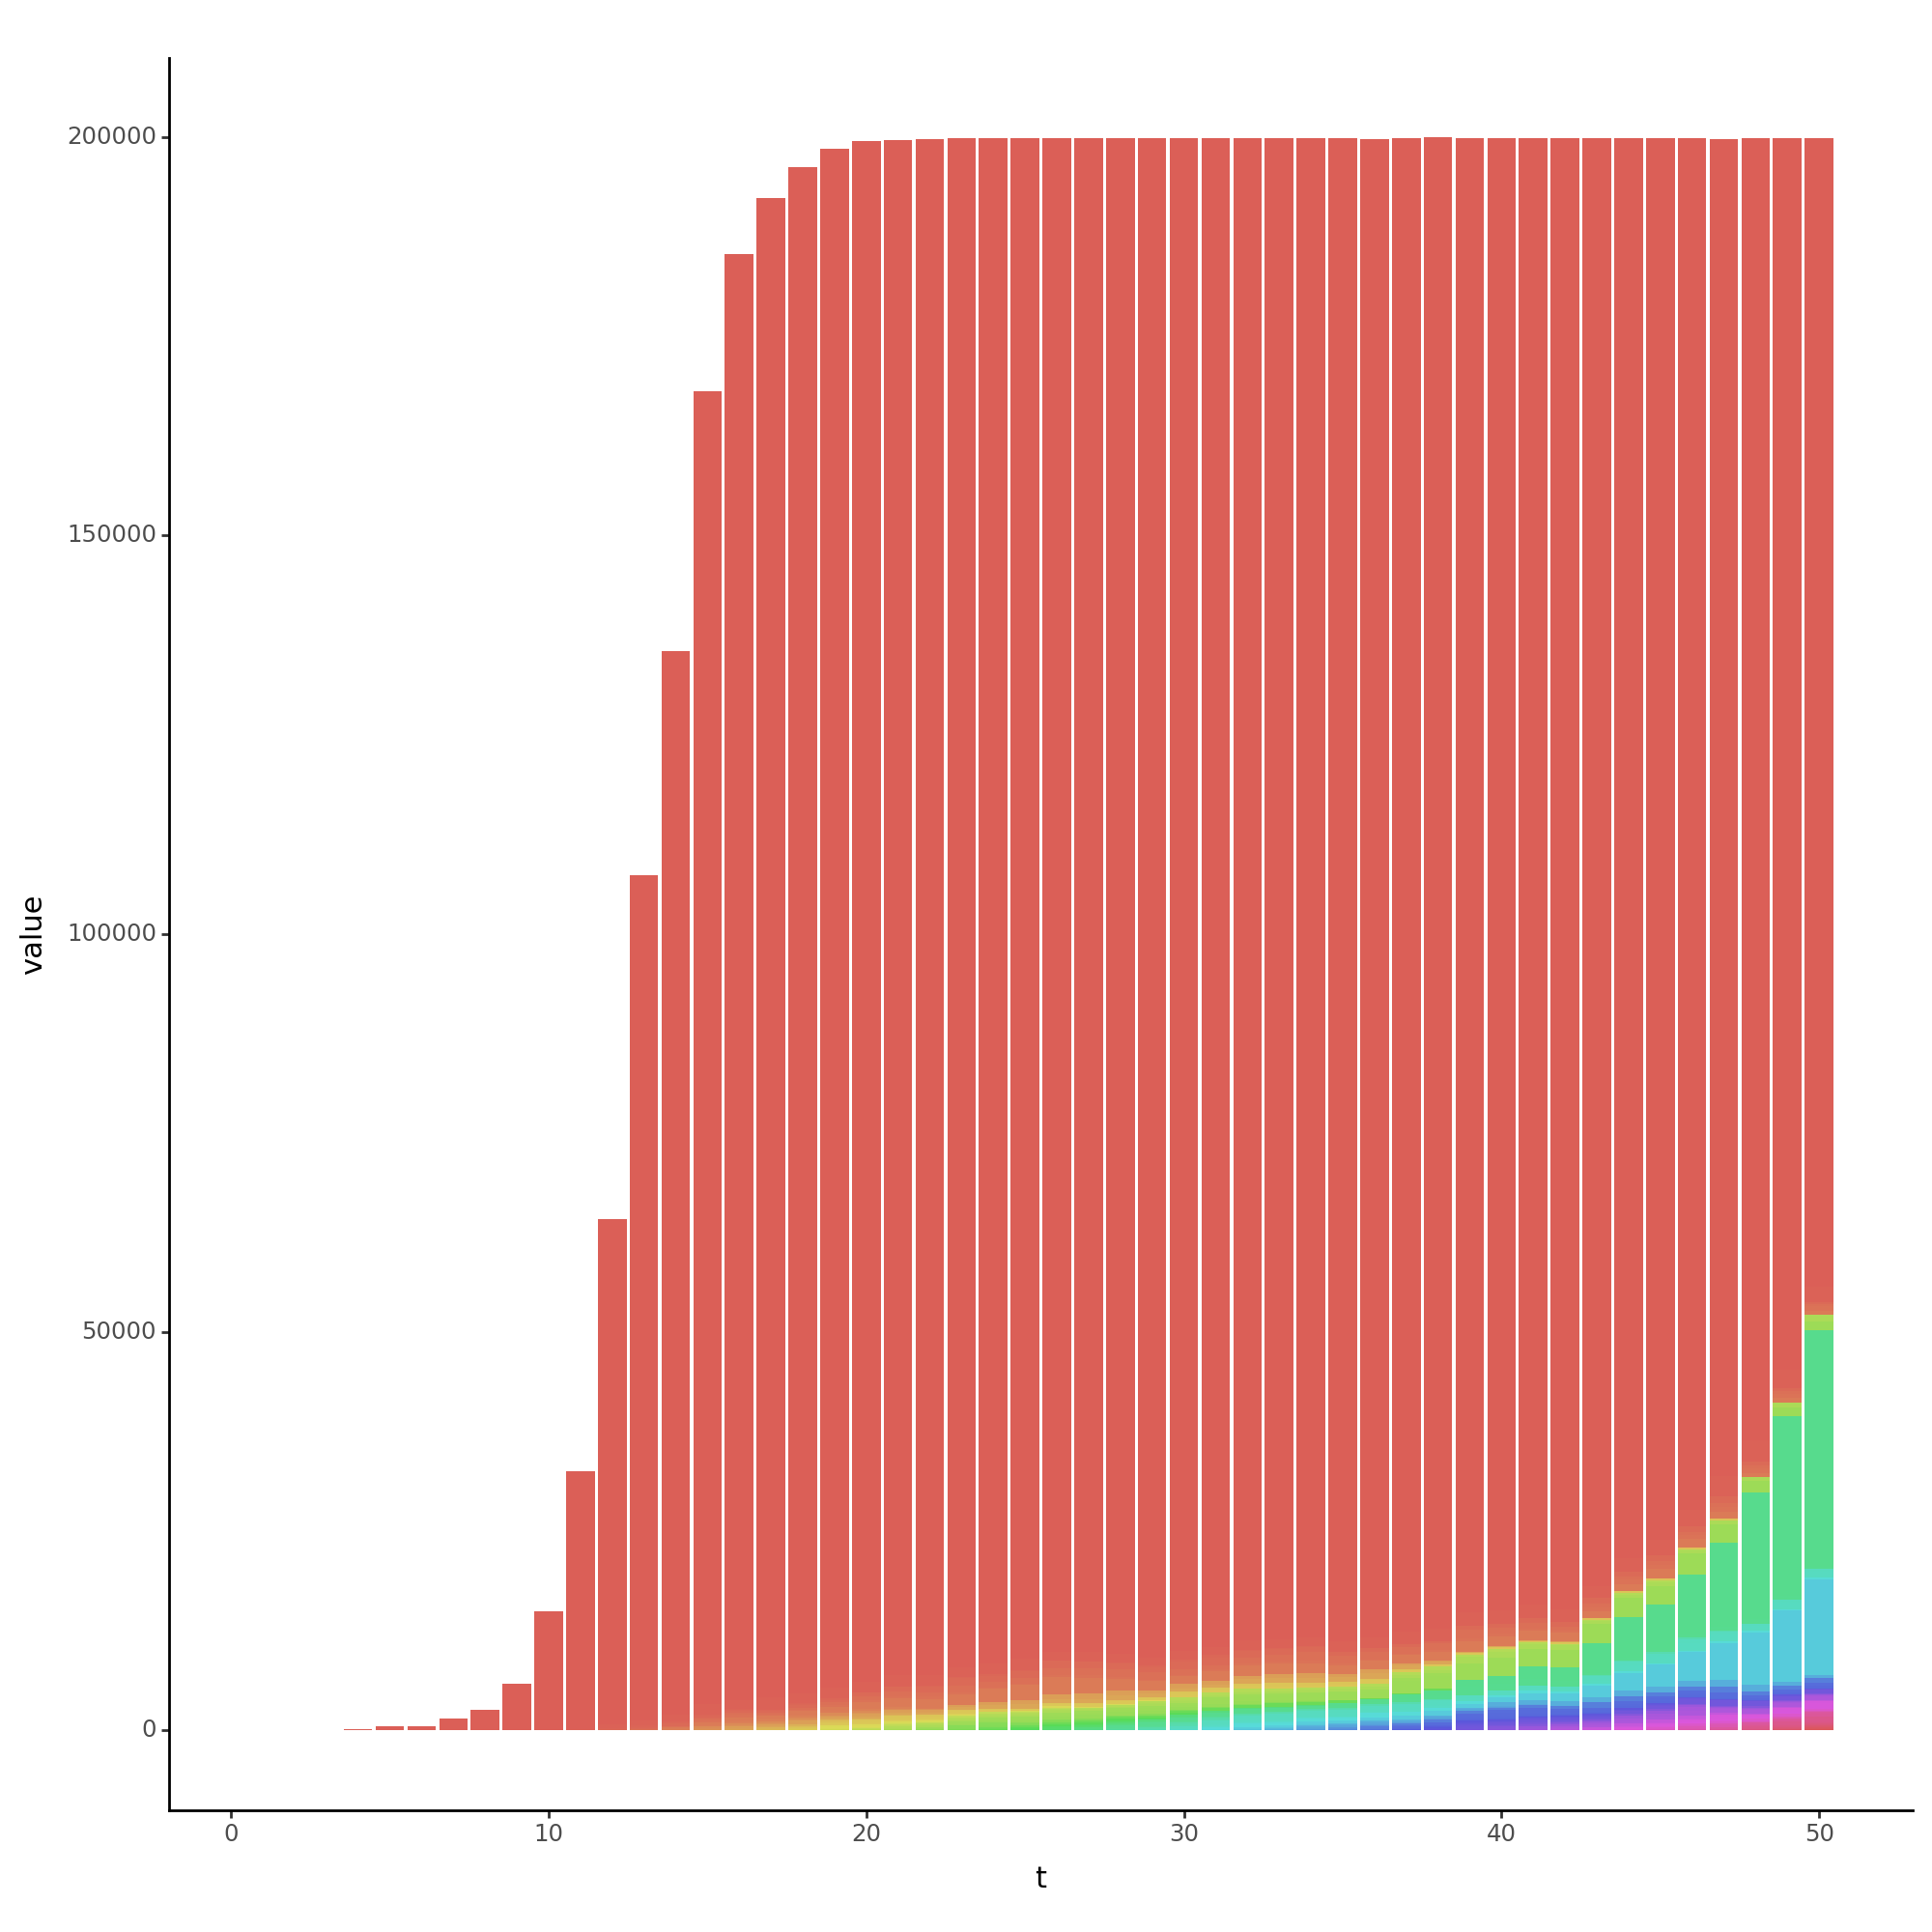

<Figure Size: (1000 x 1000)>

In [30]:
trajectory(Evo100_beneficial, plots='some')